In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

starting of paralle.py
paralle.py/parallel is printing


In [25]:
df=pd.read_parquet('tezcatli_orders_data.parquet')

In [26]:
# top 3
# C+ St Plk         689915
# C+ St NT3         425402
# Pr Plk            403583

# region top
# Midwest East              124271
# Carolinas                 105971

In [27]:
def preprocess_data(df,region,forecast):
    df=df[df['Product Segment'].isin(['Exterior','Interior'])]
    df=df[df['Region Name']!='Export/Interco']
    df=df[df['Region Name']==region]
    df=df[df['forecast_group']==forecast]
    df=df[['Order Create Date','Order Volume (STD)']]
    df['Order Create Date']=pd.to_datetime(df['Order Create Date'])
    df=df.sort_values(by='Order Create Date')
    df=df.reset_index(drop=True)
    df['year'] = df['Order Create Date'].dt.year
    df['month'] = df['Order Create Date'].dt.month
    df = df.groupby(['year', 'month'])['Order Volume (STD)'].sum().reset_index()
    df['date']=df['year'].astype('string')+'-'+df['month'].astype('string')+'-01'
    df.set_index('date',inplace=True)
    df=df.drop(['year','month'],axis=1)
    df.index=pd.to_datetime(df.index)
    return df


In [28]:
# check stationary test dickey fuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [29]:
df=preprocess_data(df,'Midwest East','C+ St Plk')

<AxesSubplot:xlabel='date'>

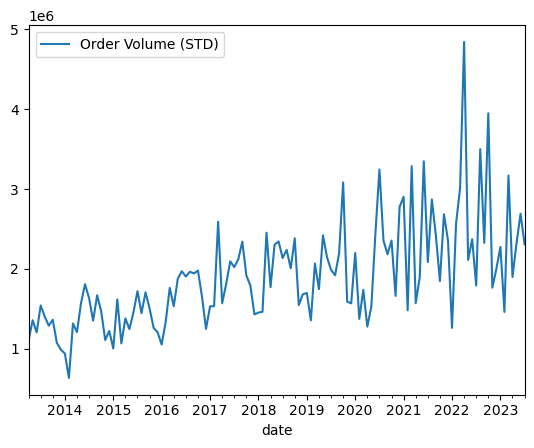

In [30]:
df.plot()

In [13]:
adf_test(df['Order Volume (STD)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.334064
p-value                   0.613448
# lags used              12.000000
# observations          111.000000
critical value (1%)      -3.490683
critical value (5%)      -2.887952
critical value (10%)     -2.580857
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [14]:
adf_test(df['Order Volume (STD)'].diff(1).dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.035304e+00
p-value                 1.386650e-07
# lags used             1.300000e+01
# observations          1.090000e+02
critical value (1%)    -3.491818e+00
critical value (5%)    -2.888444e+00
critical value (10%)   -2.581120e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# data has seasonality and it is yearly seasonal

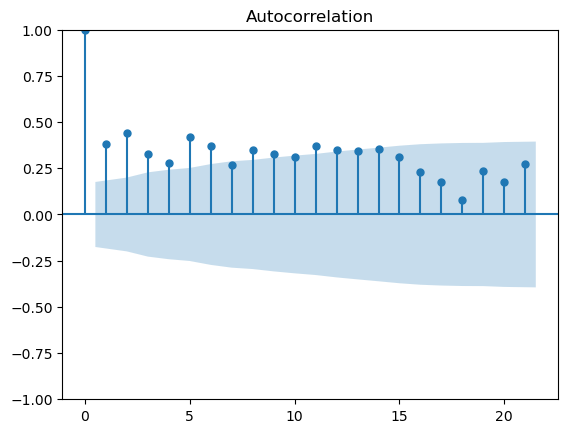

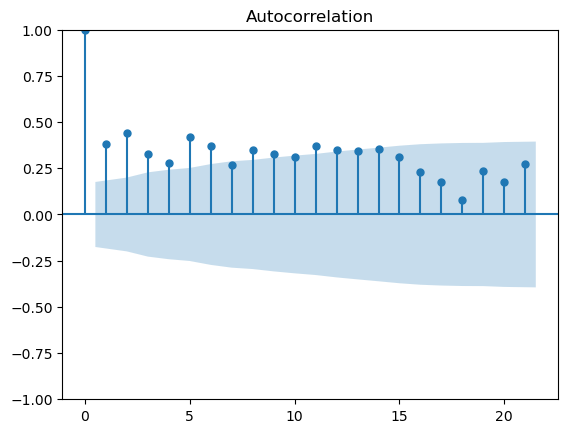

In [15]:
plot_acf(df)    

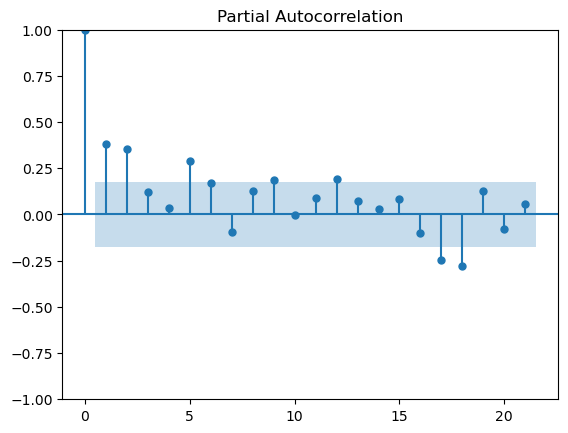

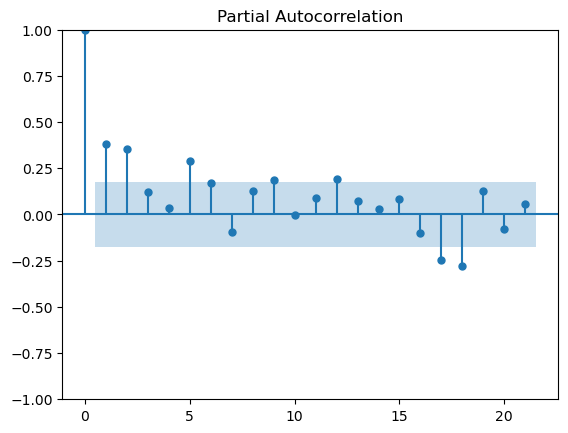

In [16]:
plot_pacf(df)

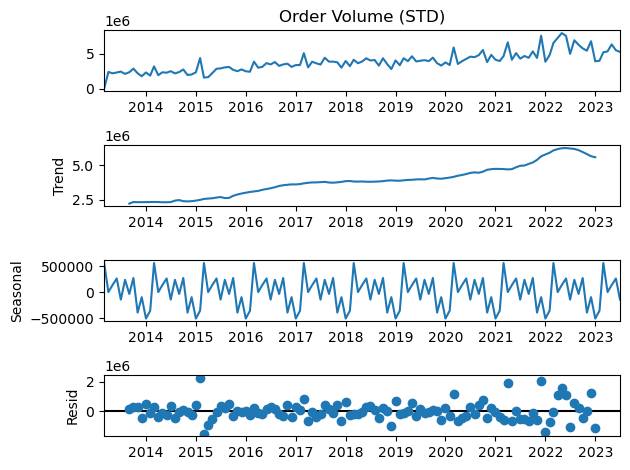

In [146]:
sd=seasonal_decompose(df['Order Volume (STD)'])
sd.plot();

<AxesSubplot:xlabel='date'>

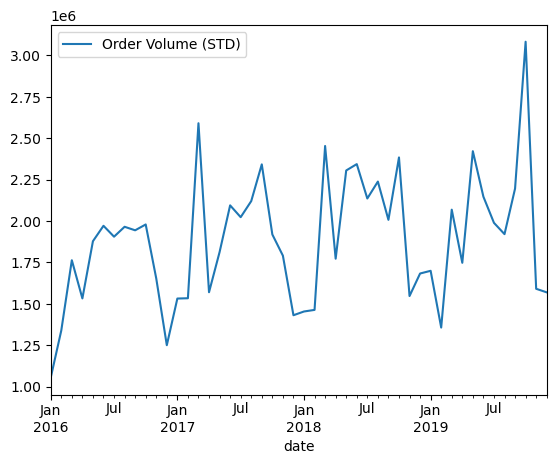

In [69]:
df['2016':'2019'].plot()

In [17]:
auto_arima(df['Order Volume (STD)'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1797.541
Date:                Tue, 29 Aug 2023   AIC                           3603.082
Time:                        10:50:16   BIC                           3614.331
Sample:                    04-01-2013   HQIC                          3607.651
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.864e+04   6674.870      2.793      0.005    5559.933    3.17e+04
ar.L1         -0.0713      0.104     -0.685      0.493      -0.275       0.133
ma.L1         -0.9284      0.064    -14.609      0.000      -1.053      -0.804
sigma2       3.46e+11   1.38e-05   2.51e+16      0.000    3.46e+11    3.46e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                48.44
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               5.96   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+34. Standard errors may be unstable.
"""

In [18]:
def allinOne_val(df,p,d,q):
    # df.plot()
    sd=seasonal_decompose(df['Order Volume (STD)'])
    sd.plot();
    auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True,m=12).summary()
    print('auto_arima_result',auto_arima_result)
    train=df[:'2021-12-01']
    val=df['2022-01-01':'2022-10-01']
    test=df['2022-11-01':]
    start=len(train)
    end=len(train) + len(val)-1
    model=SARIMAX(train['Order Volume (STD)'],order=(p, d, q))
    results=model.fit()
    predictions_val=results.predict(start,end).rename('SARIMAX  predict')
    val['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
    predictions_val.plot(legend=True)
    plt.show()
    print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(val['Order Volume (STD)'],predictions_val)*100)

auto_arima_result                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1797.541
Date:                Tue, 29 Aug 2023   AIC                           3603.082
Time:                        10:51:23   BIC                           3614.331
Sample:                    04-01-2013   HQIC                          3607.651
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.864e+04   6674.870      2.793      0.005    5559.933    3.17e+04
ar.L1         -0.0713      0.104     -0.685      0.493      -0.275       0.133
ma.L1         -0.9284      0.064  

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


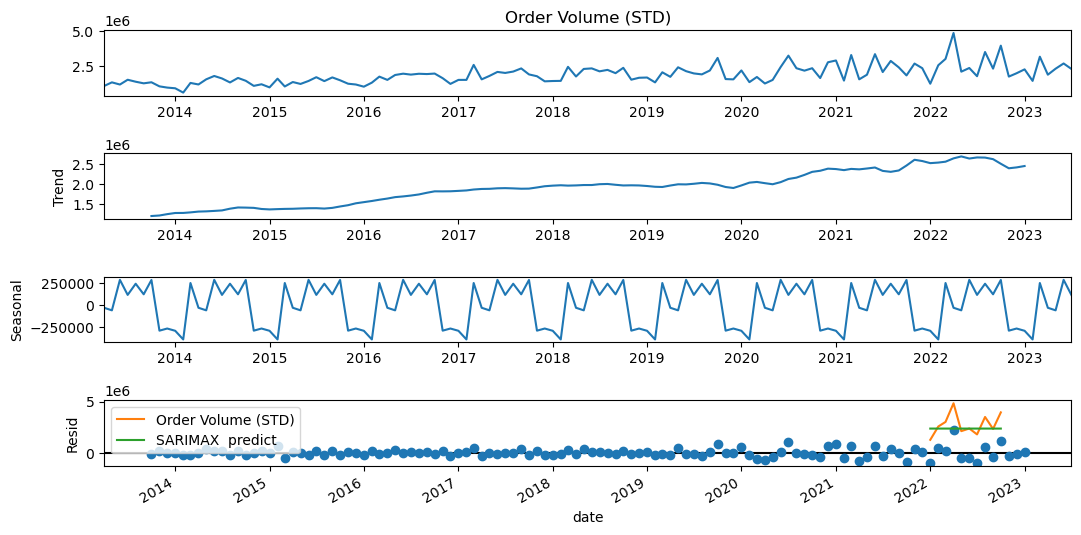

mean_absolute_percentage_error_val 28.599614370080666


In [19]:
allinOne_val(df,1,1,1)

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45130D+01    |proj g|=  1.10933D-01

At iterate    5    f=  1.44490D+01    |proj g|=  4.74194D-03

At iterate   10    f=  1.44386D+01    |proj g|=  1.90424D-02

At iterate   15    f=  1.44351D+01    |proj g|=  1.25421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   4.121D-07   1.444D+01
  F =   14.435047029069430     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


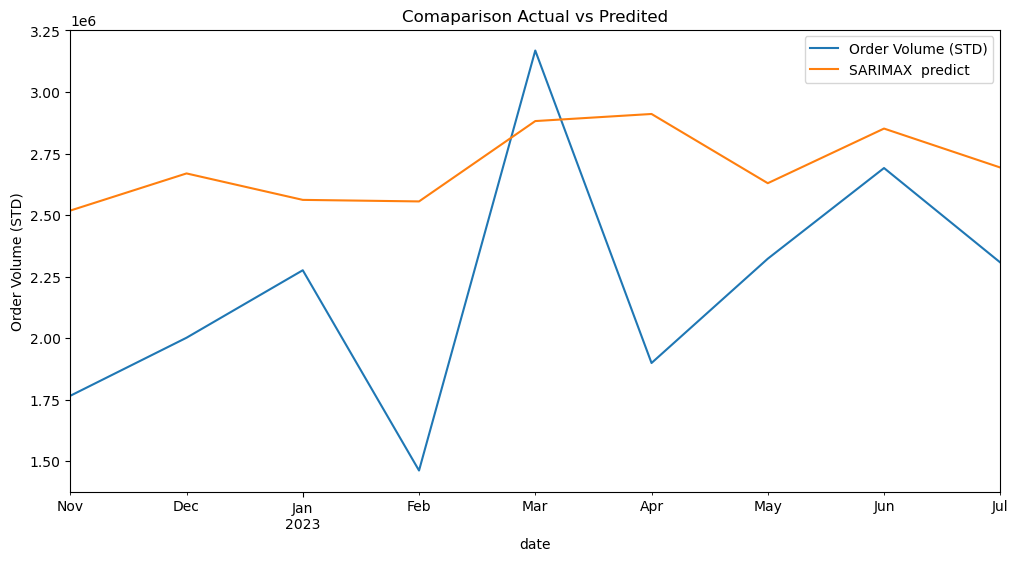

mean_absolute_percentage_error_val 29.06085696282114


In [21]:
train=df[:'2022-10-01']
# val=df[:'2022-10-01']
test=df['2022-11-01':]
start=len(train)
end=len(train) + len(test)-1
model=SARIMAX(train['Order Volume (STD)'],order=(1, 1, 1),seasonal_order=(1,0,1,12))
model.initialize_approximate_diffuse()
results=model.fit()
predictions=results.predict(start,end).rename('SARIMAX  predict')
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
predictions.plot(legend=True)
plt.ylabel('Order Volume (STD)')
plt.title('Comaparison Actual vs Predited')
plt.show()
print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions)*100)

In [151]:
start=len(train)
end=len(train) + len(test)-1

In [152]:
model=SARIMAX(train['Order Volume (STD)'],order=(1, 1, 2))

In [153]:
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49002D+01    |proj g|=  5.55047D-02

At iterate    5    f=  1.48951D+01    |proj g|=  2.67104D-03

At iterate   10    f=  1.48942D+01    |proj g|=  1.84126D-02

At iterate   15    f=  1.48916D+01    |proj g|=  1.01589D-02

At iterate   20    f=  1.48908D+01    |proj g|=  4.65547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   1.957D-06   1.489D+01
  F =   14.890796931283113     

CONVERG

 This problem is unconstrained.


In [154]:
predictions=results.predict(start,end).rename('SARIMAX  predict')

<AxesSubplot:xlabel='date'>

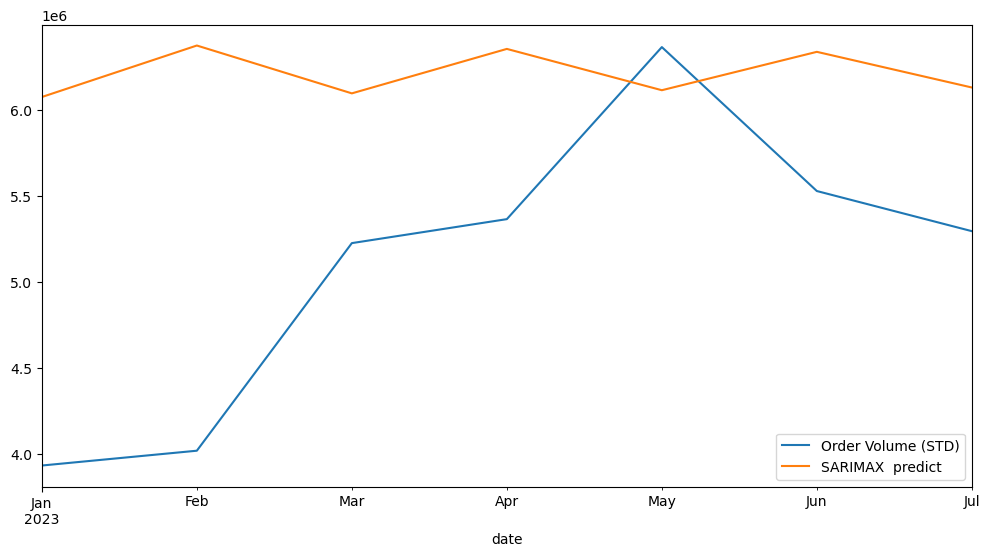

In [155]:
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
predictions.plot(legend=True)

In [156]:
mean_absolute_percentage_error(test['Order Volume (STD)'],predictions)

0.26037215592655166

In [157]:
mean_absolute_error(test['Order Volume (STD)'],predictions)

1177329.4768611414

In [85]:
model2=SARIMAX(train['Order Volume (STD)'],order=(4, 1, 2))

In [86]:
results2=model2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42277D+01    |proj g|=  7.27553D-02

At iterate    5    f=  1.42064D+01    |proj g|=  2.55422D-02

At iterate   10    f=  1.42027D+01    |proj g|=  2.04376D-02

At iterate   15    f=  1.42022D+01    |proj g|=  1.27015D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     20      1     0     0   1.466D-05   1.420D+01
  F =   14.202188330209268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [87]:
predictions2=results2.predict(start,end).rename('SARIMAX  predict')

<AxesSubplot:xlabel='date'>

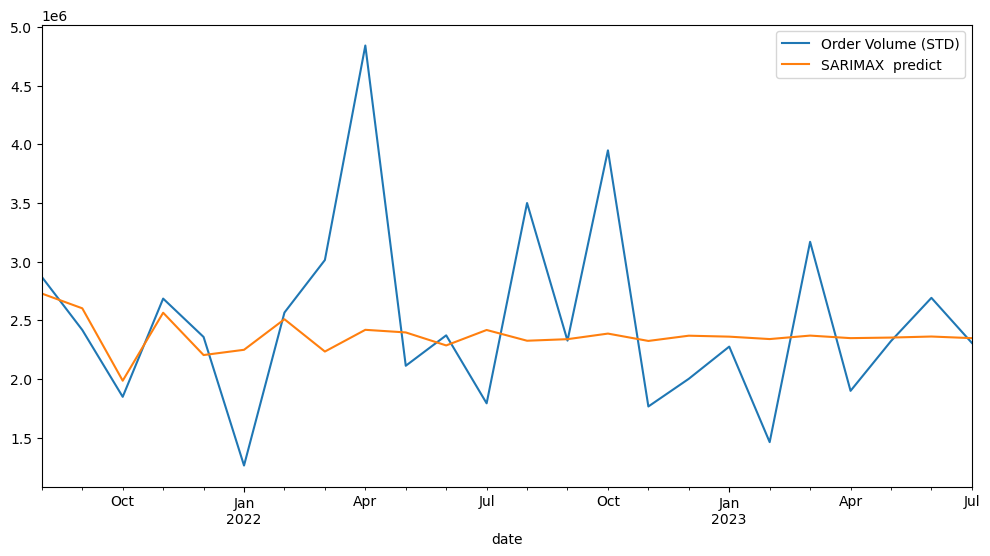

In [88]:
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
predictions2.plot(legend=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44685D+01    |proj g|=  5.62574D-01

At iterate    5    f=  1.42174D+01    |proj g|=  4.72978D-02

At iterate   10    f=  1.42056D+01    |proj g|=  3.01299D-02

At iterate   15    f=  1.42049D+01    |proj g|=  3.52624D-03

At iterate   20    f=  1.42048D+01    |proj g|=  1.61847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     24      1     0     0   3.459D-05   1.420D+01
  F =   14.204844418338535     

CONVERG

 This problem is unconstrained.


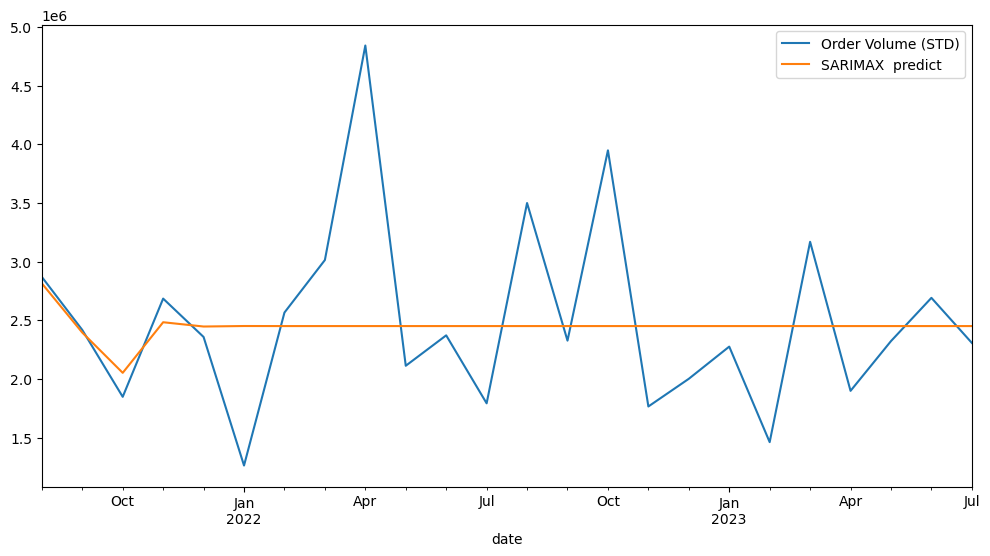

In [97]:
model2=SARIMAX(train['Order Volume (STD)'],order=(1, 1, 5))
results2=model2.fit()
predictions2=results2.predict(start,end).rename('SARIMAX  predict')
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
predictions2.plot(legend=True)
print('mean_absolute_error',mean_absolute_error(test['Order Volume (STD)'],predictions2))

### Final 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54361D+01    |proj g|=  1.31454D+00

At iterate    5    f=  1.48723D+01    |proj g|=  8.02175D-02

At iterate   10    f=  1.48475D+01    |proj g|=  4.47439D-02

At iterate   15    f=  1.48316D+01    |proj g|=  7.89381D-02

At iterate   20    f=  1.48243D+01    |proj g|=  3.80701D-02

At iterate   25    f=  1.48152D+01    |proj g|=  1.90187D-02

At iterate   30    f=  1.48092D+01    |proj g|=  2.25683D-02

At iterate   35    f=  1.48020D+01    |proj g|=  5.34516D-02

At iterate   40    f=  1.47985D+01    |proj g|=  2.70204D-02

At iterate   45    f=  1.47968D+01    |proj g|=  1.68320D-02

At iterate   50    f=  1.47953D+01    |proj g|=  2.03236D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

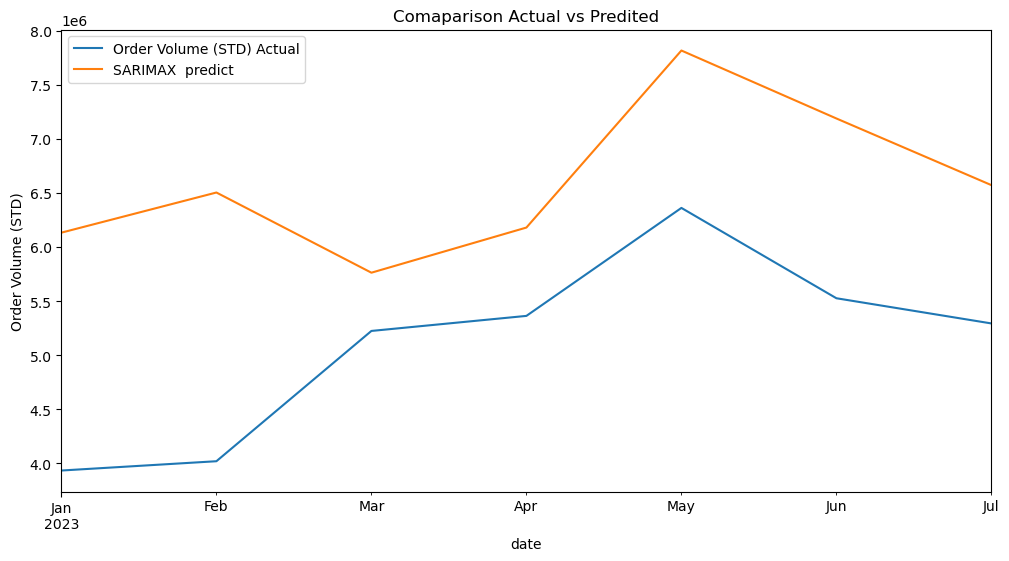

In [160]:
model2=SARIMAX(train['Order Volume (STD)'],order=(10, 1, 10))
results2=model2.fit()
predictions2=results2.predict(start,end).rename('SARIMAX  predict')
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True,label='Order Volume (STD) Actual')
predictions2.plot(legend=True)
# plt.xticks('')
plt.ylabel('Order Volume (STD)')
plt.title('Comaparison Actual vs Predited')
print('mean_absolute_error',mean_absolute_error(test['Order Volume (STD)'],predictions2))
print("MAPE",mean_absolute_percentage_error(test['Order Volume (STD)'],predictions2))

In [23]:
pd.DataFrame(predictions)

,SARIMAX predict
2022-11-01,2.518285e+06
2022-12-01,2.669203e+06
2023-01-01,2.561729e+06
2023-02-01,2.555462e+06
2023-03-01,2.881961e+06
2023-04-01,2.910768e+06
2023-05-01,2.629496e+06
2023-06-01,2.851484e+06
2023-07-01,2.693239e+06


In [24]:
test

,Order Volume (STD)
date,
2022-11-01,1765748.75
2022-12-01,2001589.75
2023-01-01,2275803.75
2023-02-01,1462045.50
2023-03-01,3168607.75
2023-04-01,1898904.00
2023-05-01,2322702.25
2023-06-01,2691159.50
2023-07-01,2307326.75


In [100]:
print('mean_absolute_error',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions2))

mean_absolute_error 0.24822447227562425


In [93]:
predictions2

2021-08-01    2.639119e+06
2021-09-01    2.692089e+06
2021-10-01    1.991095e+06
2021-11-01    2.792500e+06
2021-12-01    2.509510e+06
2022-01-01    2.462822e+06
2022-02-01    2.516511e+06
2022-03-01    2.754838e+06
2022-04-01    2.554738e+06
2022-05-01    2.687701e+06
2022-06-01    2.760068e+06
2022-07-01    2.654390e+06
2022-08-01    2.679578e+06
2022-09-01    2.797637e+06
2022-10-01    2.654871e+06
2022-11-01    2.703118e+06
2022-12-01    2.781000e+06
2023-01-01    2.677991e+06
2023-02-01    2.695517e+06
2023-03-01    2.782104e+06
2023-04-01    2.680950e+06
2023-05-01    2.700089e+06
2023-06-01    2.772341e+06
2023-07-01    2.690524e+06
2023-08-01    2.698041e+06
2023-09-01    2.768176e+06
2023-10-01    2.694772e+06
2023-11-01    2.699564e+06
2023-12-01    2.761830e+06
2024-01-01    2.700262e+06
Freq: MS, Name: SARIMAX  predict, dtype: float64